<a href="https://colab.research.google.com/github/Uskmbv/HWPanda_Uskembayeva/blob/main/04_LM_PP_Attachment_classification_AltynUskembayeva.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PP Attachment

The Preposition Phrase attachment problem is the difficulty to decide if a preposition in a sentence is attached to a verb or a noun.

In some cases it may even confuse the reader. For example, the sentence:

> San Jose cops kill man with a knife

can be interpreted as either the man or the cops had a knife. The difference in the syntax parsing would be attaching the preposition phrase either to the Verb Phrase ("kill with knife")

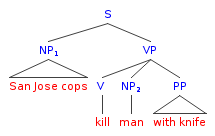

or to the Noun Phrase ("man with knife").

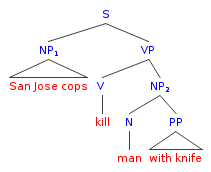


Let's try out the Preposition Phrase attachment classification!

Through this exercise, you'll practice classification of linguistic aspects of text.

# Setup
Loading the data

In [5]:
import csv

from tqdm.notebook import tqdm
from typing import Dict, List, Tuple
from random import choice
from urllib.request import urlopen


In [6]:
def read_pp_examples(file_url: str) -> List[Dict]:
  """Reads the pp samples from a remtoe url and loads them into a dictionary

  Args:
      file_url (str): a url to load the dataset from

  Returns:
      Dict: a dictionary with two keys: answer and pp
  """
  pp_examples = []

  for line in tqdm(urlopen(file_url)):
    line = line.decode("utf-8").strip().split()
    assert(len(line) == 5)
    v,n1,p,n2,answer = line
    pp_examples.append( {'answer':answer,'keywords':(v,n1,p,n2)} )
  return pp_examples

In [7]:
pp_samples_url = 'https://raw.githubusercontent.com/liadmagen/NLP-Course/master/dataset/pp_examples.txt'

In [8]:
pp_examples = read_pp_examples(pp_samples_url)


0it [00:00, ?it/s]

# Step #1 - Look at the data

Step 1 is (always) to examine the data!

That means to check the data statistics, load some sample at random and ensure it is correctly labeled, and if possible, plot and visualize the data (histograms, distribution, etc.).

In [9]:
print(f"There are {len(pp_examples)} samples in the dataset")

There are 25858 samples in the dataset


In [10]:
print(choice(pp_examples))

{'answer': 'N', 'keywords': ('been', 'president', 'for', 'advertising')}


Of course, we can reach the dictionary's parts by specifying the key in a squared brackets.

In [11]:
random_example = choice(pp_examples)
random_example['keywords']

('want', 'experience', 'in', 'field')

In [12]:
random_example['answer']

'N'

# Step 2: Deciding on the measurement

In [13]:
# we can split the dataset simply through dividing the list

amt = int(0.75 * len(pp_examples))
train_examples, test_examples = pp_examples[:amt], pp_examples[amt:]

print(len(train_examples), len(test_examples))

19393 6465


We'll define a classifier evaluator.

Given a set of examples and an evaluator, it returns the accuracy score

In [15]:
def evaluate_classifier(examples, pp_resolver):
  """evaluate the classifier and returns the accuracy score.

  Args:
      examples (List): a list of {'keywords':(v,n1,p,n2), 'answer':answer }
      pp_resolver (_type_): a model with a classify() function that maps from
        (v,n1,p,n2) to 'N' / 'V'

  Returns:
      float: The accurcy score of the classifier
  """
  correct = 0.0
  incorrect = 0.0
  for example in examples:
      answer = pp_resolver.classify(example['keywords'])
      if answer == example['answer']:
          correct += 1
      else:
          incorrect += 1
  return correct / (correct + incorrect)


# Classifiers

Let's test it on an extremely naive classifiers:

In [16]:
class AlwaysSayN:
    """
    This naive clasifier answers always with 'Noun'
    """
    def __init__(self): pass
    def classify(self, pp):
        return 'N'


In [17]:
class AlwaysSayV:
    """
    This naive clasifier answers always with 'Verb'
    """
    def __init__(self): pass
    def classify(self, pp):
        return 'V'


In [18]:
evaluate_classifier(test_examples, AlwaysSayV())

0.4634184068058778

In [19]:
evaluate_classifier(test_examples, AlwaysSayN())

0.5365815931941222

We can see that saying always 'Noun', leads to an accuracy result of 53%.

---



It also means that our dataset is quite balaneced ;)

We could, instead, have tested which class has the majority and simply select it:

In [28]:
class MajorityClassResolver:
  def __init__(self, training_examples: List):
    """Initializes the class, testing which class is the majority and saves it as a property.

    Args:
        training_examples (List): A list of dictionary training examples.
    """
    answers = [item['answer'] for item in training_examples]
    num_n = len([a for a in answers if a == 'N'])
    num_v = len([a for a in answers if a == 'V'])
    if num_v > num_n:
        self.answer = 'V'
    else:
        self.answer = 'N'

  def classify(self, pp: Tuple) -> str:
    """classify a 4 keywords tuple as N or V attachment, based on the previously calculated majority class

    Args:
        pp (Tuple): a tuple of V, N1, PP, N2 to be classified

    Returns:
        str: the prediction - N or V
    """
    return self.answer


In [29]:
evaluate_classifier(test_examples, MajorityClassResolver(train_examples))

0.5365815931941222

Or make it a bit more sophisticated by peeking at the training examples:

In [30]:
class LookupResolver:
  def __init__(self, training_examples: List):
    """Initializes the class, load all the training dataset into the memory and during prediction, return the answer if the keywords match a previously saved one.

    Args:
        training_examples (List): _description_
    """
    self.answers = {}
    for item in training_examples:
        self.answers[item['keywords']] = item['answer']
    self.backoff = MajorityClassResolver(training_examples)

  def classify(self, pp: Tuple) -> str:
    """Classify a 4 keywords tuple as N or V attachment.
     If the tuple was found in the previously stored answers, return it.
     Otherwise, return the majority class.

    Args:
        pp (Tuple): a tuple of V, N1, PP, N2 to be classified

    Returns:
        str: the prediction - N or V
    """
    if pp in self.answers:
        return self.answers[pp]
    else:
        return self.backoff.classify(pp)

In [32]:
# If you want to understand what is stored in the `answers` property, uncomment and run the following line:
# lookupResolver(train_examples).answers

In [33]:
evaluate_classifier(test_examples, LookupResolver(train_examples))

0.6009280742459396

# Exercise - Your Turn:

Implement a discriminative PP-attachment model, using a classifier of your choice (i.e. - Naive Bayes Classifier https://web.stanford.edu/~jurafsky/slp3/4.pdf, [Support Vector Machine](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#sklearn.svm.SVC), etc.) from a toolkit such as [sklearn](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.GaussianNB.html#sklearn.naive_bayes.GaussianNB).

Please take a good look at the data beforehand. Try to answer questions such as:
- What is the frequency of the propesitions?
- Which prepositions are a clear indicator to be almost only V or N? Or in other words, which pair frequency of preposition and the answer is above 90?
- Which prepositionas are relatively "confusing"? e.g., their frequency is almost equal for V and N.
- Which words are frequent as verbs? as first noun? as second noun?

Regarding the model itself, try to think which features may be helpful.

Possible features for back-off algorithm or ML one:

Single items ​
* Identity of v ​
* Identity of p ​
* Identity of n1 ​
* Identity of n2 ​

Pairs:​
* dentity of (v, p) ​
* Identity of (n1, p) ​
* Identity of (p, n1)​

Triplets:​
* Identity of (v, n1, p)​
* Identity of (v, p, n2) ​
* Identity of (n1, p, n2) ​

Quadruple:​
* Identity of (v, n1, p, n2)​


Corpus Level:​

* Have we seen the (v, p) pair in a 5-word window in a big corpus?​
* Have we seen the (n1, p) pair in a 5-word window in a big corpus? ​
* Have we seen the (n1, p, n2) triplet in a 5-word window in a big corpus?​
*  Also: we can use counts, or binned counts.​
* You can use a bigger corpus for additional training purposes as well.

If we had the original sentnces, we could have used a distance feature, such as:​
* Distance (in words) between v and p ​
* Distance (in words) between n1 and p​

However, you can try implementing the average distance (in words) from a larger corpus.

Additionally, think which other methods we learned that could help. Looking at the data might give you some ideas.


For the corpus level features, you can simply load one of the english corpuses in NLTK (such as [brown - but don't forget to download it first](https://www.nltk.org/book/ch02.html)). If you use a tagged corpus - such that the words are tagged by their parts of speech, you can create more interesting linguistic-related features.

You can also consider using [WordNet](https://wordnet.princeton.edu/), a large *lexical* database of English words, which is also [implemented in NLTK](https://www.nltk.org/howto/wordnet.html).

Finally, if you need inspiration and ideas, here are some selected papers:
- [An Analysis of Prepositional-Phrase Attachment Disambiguation](http://ejournals.asia/stj1/ijclr2.pdf) - an overview of different papers dealing with this problem using different methods (kNN, SVN, etc.).
- [The spy saw a cop with a telescope: Who has the telescope?](https://www.semanticscholar.org/paper/The-spy-saw-a-cop-with-a-telescope%3A-Who-has-the-Yan-Nguyen/3220ad0619b72404cb9b1acb9e093a8a564f0f4e) - An linguistic analysis of the potentials reasons (and features) to disambiguify pp attachment.
- [PREPOSITIONAL PHRASE ATTACHMENT AMBIGUITY RESOLUTION USING SEMANTIC HIERARCHIES](https://eprints.mdx.ac.uk/2471/1/ppattachhier.pdf)
- [Corpus Based PP Attachment Ambiguity Resolution with a Semantic Dictionary](https://aclanthology.org/W97-0109.pdf)

In [36]:
import csv
from tqdm.notebook import tqdm
from typing import Dict, List, Tuple
from random import choice
from urllib.request import urlopen
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction import DictVectorizer
from nltk import download, word_tokenize
from nltk.corpus import brown

download('brown')
download('punkt')




[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Package brown is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [44]:
# step 1 loading data

def read_pp_examples(file_url: str) -> List[Dict]:
    pp_examples = []
    for line in tqdm(urlopen(file_url)):
        line = line.decode("utf-8").strip().split()
        assert(len(line) == 5)
        v, n1, p, n2, answer = line
        pp_examples.append({'answer': answer, 'keywords': (v, n1, p, n2)})
    return pp_examples

pp_samples_url = 'https://raw.githubusercontent.com/liadmagen/NLP-Course/master/dataset/pp_examples.txt'
pp_examples = read_pp_examples(pp_samples_url)

0it [00:00, ?it/s]

In [45]:
# step 2: exploring data
prepositions = [example['keywords'][2] for example in pp_examples]
preposition_counts = {preposition: prepositions.count(preposition) for preposition in set(prepositions)}
print("Preposition Frequencies:", preposition_counts)


Preposition Frequencies: {'Till': 1, 'of': 6727, 'toward': 38, 'behind': 19, 'by': 560, 'across': 23, 'above': 27, 'unto': 1, 'Around': 1, 'besides': 1, 'off': 28, 'below': 16, 'per': 16, 'like': 46, 'onto': 5, 'after': 153, 'near': 6, 'past': 4, 'beyond': 13, 'up': 3, 'out': 4, 'WITH': 1, 'amid': 26, 'as': 660, 'pending': 1, 'during': 135, 'upon': 11, 'through': 170, 'until': 51, 'From': 1, 'against': 193, 'throughout': 18, 'down': 3, 'around': 31, 'On': 1, 'from': 1649, 'amongst': 1, 'alongside': 2, 'unlike': 2, 'via': 10, 'for': 2763, 'vs.': 1, 'over': 214, 'inside': 7, 'about': 242, 'despite': 32, 'without': 67, 'than': 108, 'beside': 1, 'among': 93, 'on': 1603, 'versus': 1, 'between': 143, 'In': 2, 'in': 4428, 'under': 124, 'into': 292, 'before': 82, 'beneath': 4, 'next': 2, 'along': 11, 'since': 100, 'with': 1106, 'within': 61, 'aboard': 1, 'except': 5, 'towards': 2, 'to': 2754, 'at': 941, 'outside': 8, 'For': 2}


In [46]:
# step 3 exploring word frequencies
verbs = [example['keywords'][0] for example in pp_examples]
nouns1 = [example['keywords'][1] for example in pp_examples]
nouns2 = [example['keywords'][3] for example in pp_examples]

print("Top Verbs:", set(verbs))
print("Top Nouns1:", set(nouns1))
print("Top Nouns2:", set(nouns2))

Top Verbs: {'selects', 'involves', 'demand', 'divide', 'announce', 'postponed', 'resisted', 'radioing', 'reporting', 'blasting', 'dispute', 'boost', 'take', 'pulls', 'induce', 'haul', 'remanded', 'amortize', 'reckoning', 'waive', 'map', 'involve', 'propelled', 'signaled', 'scanning', 'misrepresented', 'ending', 'opposing', 'wrestle', 'questioning', 'commencing', 'assigned', 'pits', 'contributed', 'socialize', 'handles', 'expresses', 'speaking', 'slashing', 'cited', 'eliminating', 'eked', 'exposed', 'forging', 'considering', 'Sharing', 'heating', 'rescheduled', 'emboldened', 'land', 'release', 'originating', 'elected', 'phoned', 'pick', 'kicks', 'totaled', 'orchestrating', 'concerns', 'reshape', 'refused', 'swear', 'comparing', 'spared', 'stem', 'attracts', 'hampered', 'start', 'generated', 'shrouded', 'needed', 'scuttled', 'dabs', 'reaching', 'delivered', 'close', 'risk', 'slipping', 'firmed', 'quoting', 'looking', 're-establishing', 'emphasizes', 'outweigh', 'reclaims', 'manipulating'

In [67]:
# step 4 implementing my classifier
class AdvancedClassifier:
    def __init__(self):
        self.vectorizer = DictVectorizer()
        self.model = MultinomialNB()

    def extract_features(self, keywords):
        v, n1, p, n2 = keywords

        # Example: Feature extraction based on word frequencies
        features = {
            'v_freq': verbs.count(v),
            'n1_freq': nouns1.count(n1),
            'n2_freq': nouns2.count(n2),
            'preposition': p.lower(),
            'v_n1_same_last_char': int(v[-1] == n1[-1]),  # Example: Check if the last character of v and n1 is the same
            'v_n1_length_diff': abs(len(v) - len(n1)),  # Example: Absolute difference in length between v and n1
        }

        return features

    def train(self, training_examples):
        X = [self.extract_features(example['keywords']) for example in training_examples]
        y = [example['answer'] for example in training_examples]

        X = self.vectorizer.fit_transform(X)
        self.model.fit(X, y)

    def classify(self, keywords):
        features = self.extract_features(keywords)
        features_vectorized = self.vectorizer.transform(features)
        return self.model.predict(features_vectorized)[0]

# extra feature exploration
v_n1_same_last_char_count = sum(int(example['keywords'][0][-1] == example['keywords'][1][-1]) for example in pp_examples)
print("v_n1_same_last_char_count:", v_n1_same_last_char_count)

v_n1_length_diff_values = [abs(len(example['keywords'][0]) - len(example['keywords'][1])) for example in pp_examples]
print("v_n1_length_diff_values:", set(v_n1_length_diff_values))

# step 5
classifier = AdvancedClassifier()
classifier.train(train_examples)
accuracy = evaluate_classifier(test_examples, classifier)
print(f"Accuracy of the Advanced Classifier: {accuracy * 100:.2f}%")



v_n1_same_last_char_count: 2188
v_n1_length_diff_values: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 18}
Accuracy of the Advanced Classifier: 58.22%


## On Generating N-Grams

In [64]:
from sklearn.feature_extraction.text import CountVectorizer

The input of *any* machine learning model must be numerical. Since words (nor characters) aren’t numbers, we have to work a bit to convert them into a numerical representation.

Such a numerical representation is also called a vector (a fancy name for a list of numbers…). A common way to achieve such vector is to perform measurements on the text (as we discussed in the first sessions – performing measurement on an apple).

Such features could be the identity of a single word, given as an index number, or its frequency in a corpus or in the sentence, or TF-IDF on a corpus. Features can also be a composition of multiple words together (e.g., only the verb and the preposition), with the same or other techniques. This is also called an **n-gram**.

One way to vectorize text is using that count transformer ([CountVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html)) from scikit-learn. These vectorizers work in two part:
*	First they learn ([fit](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html#sklearn.feature_extraction.text.CountVectorizer.fit)) from some input data. In the case of CountVectorizer, it expects a list of sentences (a corpus) to learn from. It will then learn how many different words (types) the corpus contains, and will build a vocabulary for those words: each word will get an index number. It also cleans up the text from stop words and punctuation, and you could even ask it to learn representations of n-grams, instead of single words (a parameter of the CountVectorizer itself).
*	After learning the size of the vocabulary, it can transform any list of text into a vectorized representation. Given a list of new text inputs, sentences in different lengths (also the list itself can be any length – for example, it can be made of a single sentence, but it has to be a list), the [transform](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html#sklearn.feature_extraction.text.CountVectorizer.transform) method will return a vector representation in the size of the learned vocabulary, where every position represent a specific word (a type) from the learned corpus. The value on that position is the number of occurrences of that word in that given sentence. Piling up these three vectors, one on top of the other, would yield a matrix (a table / excel sheet of numbers), where every column represent a specific word in our vocabulary.
*	`X_transformed = vectorizer.fit_transform(X)` ▶ [fit_transform](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html#sklearn.feature_extraction.text.CountVectorizer.fit_transform) is a method that does both parts (fitting – counting the vocabulary types, and then converting that input text into the vector or even a matrix if there are more than one string) in one go.
*	The result of the CountVectorizer is indeed a (sparse) matrix in a form of scipy’s scr_matrix. To convert it into an array, you can call its method “toarray()”:


In [65]:
# to use the CountVectorizer, we must convert the tuples into "full" sentences;
joined_sentences = [' '.join(example['keywords']) for example in train_examples[:10]]
joined_sentences

['creating obstacle to sale',
 'restrict RTC to borrowings',
 'maintain assets of thrifts',
 'leaving spending for bailout',
 'leaving spending at $',
 'including interest over years',
 'subtracting value of assets',
 'say opponents of plan',
 'pay price of consultation',
 'want kind of flexibility']

In [ ]:
# CountVectorizer would, by default, tokenize the sentence by separating by
# spaces and collect a vocabulary from all the different words it finds:
vect = CountVectorizer()
vect.fit(joined_sentences)
print(f"vocabulary size: {len(vect.vocabulary_)}")
vect.get_feature_names_out()

vocabulary size: 31


array(['assets', 'at', 'bailout', 'borrowings', 'consultation',
       'creating', 'flexibility', 'for', 'including', 'interest', 'kind',
       'leaving', 'maintain', 'obstacle', 'of', 'opponents', 'over',
       'pay', 'plan', 'price', 'restrict', 'rtc', 'sale', 'say',
       'spending', 'subtracting', 'thrifts', 'to', 'value', 'want',
       'years'], dtype=object)

In [ ]:
# We can use it to generate n-grams sized 1 (unigram) to 4:
vect = CountVectorizer(ngram_range=(1, 4))
vect.fit(joined_sentences)
print(f"vocabulary size: {len(vect.vocabulary_)}")
vect.get_feature_names_out()

vocabulary size: 87


array(['assets', 'assets of', 'assets of thrifts', 'at', 'bailout',
       'borrowings', 'consultation', 'creating', 'creating obstacle',
       'creating obstacle to', 'creating obstacle to sale', 'flexibility',
       'for', 'for bailout', 'including', 'including interest',
       'including interest over', 'including interest over years',
       'interest', 'interest over', 'interest over years', 'kind',
       'kind of', 'kind of flexibility', 'leaving', 'leaving spending',
       'leaving spending at', 'leaving spending for',
       'leaving spending for bailout', 'maintain', 'maintain assets',
       'maintain assets of', 'maintain assets of thrifts', 'obstacle',
       'obstacle to', 'obstacle to sale', 'of', 'of assets',
       'of consultation', 'of flexibility', 'of plan', 'of thrifts',
       'opponents', 'opponents of', 'opponents of plan', 'over',
       'over years', 'pay', 'pay price', 'pay price of',
       'pay price of consultation', 'plan', 'price', 'price of',
     